# Table of Contents

1. [Imports & Global Constants](#Imports-&-Global-Constants)
<br>&emsp;- 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
<br>

2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset)
<br>&emsp;- 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
<br>

3. [Define Dataset Class](#Define-Dataset-Class)
<br>&emsp;- 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
<br>

4. [Check Data Sample](#Check-Data-Sample)
<br>&emsp;- 제공된 데이터가 어떤 모습인지 확인합니다.
<br>

5. [Setup Dataloader](#Setup-Dataloader)
<br>&emsp;- 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
<br>

6. [Define Functions for Training](#Define-Functions-for-Training)
<br>&emsp;- 학습을 도와주는 함수들을 정의합니다.
<br>

7. [Training](#Training)
<br>&emsp;- 학습을 진행합니다.
<br>

8. [Inference](#Inference)
<br>&emsp;- 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
<br>

9. [Result Visualization](#Result-Visualization)
<br>&emsp;- 인퍼런스 결과를 확인해봅니다.
<br>

10. [To CSV](#To-CSV)
<br>&emsp;- 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [1]:
# # 노트북 실행에 필요한 라이브러리를 설치합니다

# !pip install opencv-python-headless==4.10.0.84
# !pip install pandas==2.2.3
# !pip install -U scikit-learn==1.5.2
# !pip install albumentations==1.4.18
# !pip install matplotlib==3.9.2

In [2]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/level2-cv-semanticsegmentation-cv-06-lv3/data/train/DCM"
LABEL_ROOT = "/level2-cv-semanticsegmentation-cv-06-lv3/data/train/outputs_json"

In [4]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [5]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [6]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [7]:
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
K_SPLITS = 5

LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 100
VAL_EVERY = 20

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [8]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [9]:
print("Sample PNG paths:", list(pngs)[:5])

Sample PNG paths: ['ID428/image1666059689193.png', 'ID404/image1665540070459.png', 'ID289/image1664157014295.png', 'ID501/image1666746629213.png', 'ID091/image1661821925422.png']


In [10]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [11]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [12]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [13]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [14]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [15]:
class XRayDataset(Dataset):
    def __init__(self, filenames, labelnames, is_train=True, transforms=None):
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [16]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# Define Functions for Training

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [18]:
def save_model(model, file_name='fcn_resnet50_best_model.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)
    print(f"{output_path} 모델 저장 완료! ")

In [19]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [20]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = len(CLASSES)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            model = model.cuda()
            
            outputs = model(images)['out']
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # gt와 prediction의 크기가 다른 경우 prediction을 gt에 맞춰 interpolation 합니다.
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()
            
            dice = dice_coef(outputs, masks)
            dices.append(dice)
                
    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)
    
    avg_dice = torch.mean(dices_per_class).item()
    
    return avg_dice

In [21]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    
    n_class = len(CLASSES)
    best_dice = 0.
    
    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):            
            # gpu 연산을 위해 device 할당합니다.
            images, masks = images.cuda(), masks.cuda()
            model = model.cuda()
            
            outputs = model(images)['out']
            
            # loss를 계산합니다.
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따라 loss를 출력합니다.
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
             
        # validation 주기에 따라 loss를 출력하고 best model을 저장합니다.
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

In [22]:
def get_fold_data(fold_idx, gkf_split):
    """
    K-Fold의 특정 폴드 번호(fold_idx)에 해당하는 학습 및 검증 데이터를 반환합니다.
    """

    train_filenames, train_labelnames = [], []
    valid_filenames, valid_labelnames = [], []

    for i, (train_idx, valid_idx) in enumerate(gkf_split):
        if i == fold_idx:
            valid_filenames = [pngs[idx] for idx in valid_idx]
            valid_labelnames = [jsons[idx] for idx in valid_idx]
        else:
            train_filenames.extend([pngs[idx] for idx in train_idx])
            train_labelnames.extend([jsons[idx] for idx in train_idx])

    return train_filenames, train_labelnames, valid_filenames, valid_labelnames

In [23]:
def save_fold_data(fold_idx, train_filenames, train_labelnames, valid_filenames, valid_labelnames):
    """
    각 폴드의 학습 및 검증 데이터 파일 목록을 JSON 파일로 저장하고, 
    라벨 정보는 별도의 JSON 파일로 저장합니다.
    """
    # 파일 목록 JSON 저장
    file_data = {
        "train": train_filenames,
        "valid": valid_filenames
    }

    os.makedirs('k_fold_data', exist_ok=True)
    
    with open(f'k_fold_data/fold_{fold_idx + 1}_files.json', 'w') as f:
        json.dump(file_data, f, indent=4)
    print(f"[Fold {fold_idx + 1}] 파일 목록 저장 완료: fold_{fold_idx + 1}_files.json")

    # 라벨 정보 JSON 저장
    label_data = {
        "train_labels": train_labelnames,
        "valid_labels": valid_labelnames
    }
    
    with open(f'k_fold_data/fold_{fold_idx + 1}_labels.json', 'w') as f:
        json.dump(label_data, f, indent=4)
    print(f"[Fold {fold_idx + 1}] 라벨 정보 저장 완료: fold_{fold_idx + 1}_labels.json")

In [24]:
def run_kfold_training(n_splits=5):
    """
    K-Fold로 모델 학습을 반복하고, 각 폴드 별 최적의 모델을 저장합니다.
    """
    tf = A.Resize(512, 512)
    groups = [os.path.dirname(fname) for fname in pngs]
    gkf = GroupKFold(n_splits=n_splits)
    gkf_split = list(gkf.split(pngs, [0] * len(pngs), groups))  # 제너레이터를 리스트로 변환

    for fold_idx in range(n_splits):
        print(f'\n[Fold {fold_idx + 1}/{n_splits}] 시작합니다.')
        
        # K-Fold 데이터 분할
        train_filenames, train_labelnames, valid_filenames, valid_labelnames = get_fold_data(fold_idx, gkf_split)
        save_fold_data(fold_idx, train_filenames, train_labelnames, valid_filenames, valid_labelnames)
        
        # Dataset 및 DataLoader 설정
        train_dataset = XRayDataset(train_filenames, train_labelnames, is_train=True, transforms=tf)
        valid_dataset = XRayDataset(valid_filenames, valid_labelnames, is_train=False, transforms=tf)
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)
        
        # 모델 초기화
        model = models.segmentation.fcn_resnet50(pretrained=True)
        model.classifier[4] = nn.Conv2d(512, len(CLASSES), kernel_size=1)
        model = model.cuda()

        # 손실 함수 및 옵티마이저 설정
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)
        
        # 시드 설정
        set_seed()
        
        # 학습 시작
        print(f'\n[Fold {fold_idx + 1}/{n_splits}] 학습을 시작합니다.')
        train(model, train_loader, valid_loader, criterion, optimizer)

        # 폴드별 최적 모델 저장
        save_model(model, file_name=f'fcn_resnet50_best_model_fold{fold_idx + 1}.pt')

# Training

In [25]:
run_kfold_training(n_splits=K_SPLITS)


[Fold 1/5] 시작합니다.
[Fold 1] 파일 목록 저장 완료: fold_1_files.json
[Fold 1] 라벨 정보 저장 완료: fold_1_labels.json

[Fold 1/5] 학습을 시작합니다.
Start training..
2024-11-13 07:17:21 | Epoch [1/2], Step [25/640], Loss: 0.5155
2024-11-13 07:17:40 | Epoch [1/2], Step [50/640], Loss: 0.4217
2024-11-13 07:18:00 | Epoch [1/2], Step [75/640], Loss: 0.3383
2024-11-13 07:18:19 | Epoch [1/2], Step [100/640], Loss: 0.2666
2024-11-13 07:18:38 | Epoch [1/2], Step [125/640], Loss: 0.2114
2024-11-13 07:18:59 | Epoch [1/2], Step [150/640], Loss: 0.1699
2024-11-13 07:19:18 | Epoch [1/2], Step [175/640], Loss: 0.1386
2024-11-13 07:19:36 | Epoch [1/2], Step [200/640], Loss: 0.1149
2024-11-13 07:19:56 | Epoch [1/2], Step [225/640], Loss: 0.0965
2024-11-13 07:20:15 | Epoch [1/2], Step [250/640], Loss: 0.0827
2024-11-13 07:20:34 | Epoch [1/2], Step [275/640], Loss: 0.0712
2024-11-13 07:20:55 | Epoch [1/2], Step [300/640], Loss: 0.0629
2024-11-13 07:21:14 | Epoch [1/2], Step [325/640], Loss: 0.0562
2024-11-13 07:21:34 | Epoch [1/

100%|██████████| 80/80 [03:02<00:00,  2.29s/it]


finger-1    : 0.5614
finger-2    : 0.8404
finger-3    : 0.9028
finger-4    : 0.0182
finger-5    : 0.6019
finger-6    : 0.8757
finger-7    : 0.9068
finger-8    : 0.2092
finger-9    : 0.7567
finger-10   : 0.9033
finger-11   : 0.9014
finger-12   : 0.0506
finger-13   : 0.6735
finger-14   : 0.8784
finger-15   : 0.8492
finger-16   : 0.1316
finger-17   : 0.4946
finger-18   : 0.7944
finger-19   : 0.8760
Trapezium   : 0.6484
Trapezoid   : 0.1706
Capitate    : 0.7965
Hamate      : 0.6769
Scaphoid    : 0.6782
Lunate      : 0.2496
Triquetrum  : 0.3233
Pisiform    : 0.0282
Radius      : 0.9702
Ulna        : 0.9348
Best performance at epoch: 2, 0.0000 -> 0.6104
Save model in checkpoints

[Fold 2/5] 시작합니다.
[Fold 2] 파일 목록 저장 완료: fold_2_files.json
[Fold 2] 라벨 정보 저장 완료: fold_2_labels.json

[Fold 2/5] 학습을 시작합니다.
Start training..
2024-11-13 07:37:00 | Epoch [1/2], Step [25/640], Loss: 0.5446
2024-11-13 07:37:21 | Epoch [1/2], Step [50/640], Loss: 0.4455
2024-11-13 07:37:39 | Epoch [1/2], Step [75/640], Lo

100%|██████████| 80/80 [03:05<00:00,  2.31s/it]


finger-1    : 0.4042
finger-2    : 0.8253
finger-3    : 0.8856
finger-4    : 0.0001
finger-5    : 0.7025
finger-6    : 0.8825
finger-7    : 0.9268
finger-8    : 0.3922
finger-9    : 0.7338
finger-10   : 0.8760
finger-11   : 0.9061
finger-12   : 0.3038
finger-13   : 0.6598
finger-14   : 0.8640
finger-15   : 0.8438
finger-16   : 0.0000
finger-17   : 0.2398
finger-18   : 0.7962
finger-19   : 0.8628
Trapezium   : 0.6073
Trapezoid   : 0.3954
Capitate    : 0.7553
Hamate      : 0.7231
Scaphoid    : 0.6524
Lunate      : 0.4329
Triquetrum  : 0.5184
Pisiform    : 0.0164
Radius      : 0.9672
Ulna        : 0.9265
Best performance at epoch: 2, 0.0000 -> 0.6241
Save model in checkpoints

[Fold 3/5] 시작합니다.
[Fold 3] 파일 목록 저장 완료: fold_3_files.json
[Fold 3] 라벨 정보 저장 완료: fold_3_labels.json

[Fold 3/5] 학습을 시작합니다.
Start training..
2024-11-13 07:56:47 | Epoch [1/2], Step [25/640], Loss: 0.5421
2024-11-13 07:57:07 | Epoch [1/2], Step [50/640], Loss: 0.4472
2024-11-13 07:57:26 | Epoch [1/2], Step [75/640], Lo

100%|██████████| 80/80 [03:05<00:00,  2.32s/it]


finger-1    : 0.3968
finger-2    : 0.8429
finger-3    : 0.8947
finger-4    : 0.0007
finger-5    : 0.7243
finger-6    : 0.8833
finger-7    : 0.9203
finger-8    : 0.3161
finger-9    : 0.7486
finger-10   : 0.8777
finger-11   : 0.8908
finger-12   : 0.2547
finger-13   : 0.6535
finger-14   : 0.8659
finger-15   : 0.8430
finger-16   : 0.0000
finger-17   : 0.2648
finger-18   : 0.8027
finger-19   : 0.8701
Trapezium   : 0.6168
Trapezoid   : 0.3982
Capitate    : 0.7340
Hamate      : 0.7525
Scaphoid    : 0.6082
Lunate      : 0.3961
Triquetrum  : 0.5617
Pisiform    : 0.0024
Radius      : 0.9684
Ulna        : 0.9331
Best performance at epoch: 2, 0.0000 -> 0.6215
Save model in checkpoints

[Fold 4/5] 시작합니다.
[Fold 4] 파일 목록 저장 완료: fold_4_files.json
[Fold 4] 라벨 정보 저장 완료: fold_4_labels.json

[Fold 4/5] 학습을 시작합니다.
Start training..
2024-11-13 08:16:33 | Epoch [1/2], Step [25/640], Loss: 0.5468
2024-11-13 08:16:51 | Epoch [1/2], Step [50/640], Loss: 0.4502
2024-11-13 08:17:12 | Epoch [1/2], Step [75/640], Lo

100%|██████████| 80/80 [03:02<00:00,  2.28s/it]


finger-1    : 0.0511
finger-2    : 0.8091
finger-3    : 0.8584
finger-4    : 0.0000
finger-5    : 0.6721
finger-6    : 0.8649
finger-7    : 0.9073
finger-8    : 0.1161
finger-9    : 0.7160
finger-10   : 0.8559
finger-11   : 0.8828
finger-12   : 0.0080
finger-13   : 0.5411
finger-14   : 0.8523
finger-15   : 0.8231
finger-16   : 0.0000
finger-17   : 0.0022
finger-18   : 0.7619
finger-19   : 0.8282
Trapezium   : 0.5155
Trapezoid   : 0.2376
Capitate    : 0.6909
Hamate      : 0.6687
Scaphoid    : 0.5350
Lunate      : 0.3097
Triquetrum  : 0.4077
Pisiform    : 0.0000
Radius      : 0.9676
Ulna        : 0.9277
Best performance at epoch: 2, 0.0000 -> 0.5452
Save model in checkpoints

[Fold 5/5] 시작합니다.
[Fold 5] 파일 목록 저장 완료: fold_5_files.json
[Fold 5] 라벨 정보 저장 완료: fold_5_labels.json

[Fold 5/5] 학습을 시작합니다.
Start training..
2024-11-13 08:36:12 | Epoch [1/2], Step [25/640], Loss: 0.5424
2024-11-13 08:36:31 | Epoch [1/2], Step [50/640], Loss: 0.4462
2024-11-13 08:36:50 | Epoch [1/2], Step [75/640], Lo

100%|██████████| 80/80 [03:10<00:00,  2.38s/it]


finger-1    : 0.4030
finger-2    : 0.8318
finger-3    : 0.8939
finger-4    : 0.0000
finger-5    : 0.7132
finger-6    : 0.8741
finger-7    : 0.9181
finger-8    : 0.3694
finger-9    : 0.7274
finger-10   : 0.8763
finger-11   : 0.8955
finger-12   : 0.2646
finger-13   : 0.6577
finger-14   : 0.8749
finger-15   : 0.8463
finger-16   : 0.0000
finger-17   : 0.0786
finger-18   : 0.8023
finger-19   : 0.8629
Trapezium   : 0.5903
Trapezoid   : 0.3282
Capitate    : 0.7278
Hamate      : 0.7403
Scaphoid    : 0.5890
Lunate      : 0.4254
Triquetrum  : 0.5141
Pisiform    : 0.0165
Radius      : 0.9648
Ulna        : 0.9387
Best performance at epoch: 2, 0.0000 -> 0.6112
Save model in checkpoints


# Inference

In [26]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "/level2-cv-semanticsegmentation-cv-06-lv3/data/test/DCM"

In [27]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [28]:
len(pngs)

288

In [29]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [30]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [31]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [32]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)['out']
            
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [33]:
tf = A.Resize(512, 512)

In [34]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [35]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [36]:
def run_fold_inference(n_splits=5):
    """
    각 폴드 모델로 추론을 수행하고 결과를 개별 CSV 파일로 저장합니다.
    """
    for fold_idx in range(n_splits):
        print(f'\n[Fold {fold_idx + 1}/{n_splits}] 모델을 사용하여 추론을 시작합니다.')
        
        # 폴드별 모델 로드
        model_path = os.path.join(SAVED_DIR, f"fcn_resnet50_best_model_fold{fold_idx + 1}.pt")
        model = torch.load(model_path)
        
        # 폴드별 추론
        rles, filename_and_class = test(model, test_loader)
        print(filename_and_class[0])

        # 이미지 시각화
        image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

        preds = []
        for rle in rles[:len(CLASSES)]:
            pred = decode_rle_to_mask(rle, height=2048, width=2048)
            preds.append(pred)

        preds = np.stack(preds, 0)

        fig, ax = plt.subplots(1, 2, figsize=(24, 12))
        ax[0].imshow(image)    # remove channel dimension
        ax[1].imshow(label2rgb(preds))

        plt.show()
        
        # 추론 결과를 저장
        classes, filenames = zip(*[x.split("_") for x in filename_and_class])
        image_names = [os.path.basename(f) for f in filenames]
        
        df = pd.DataFrame({
            "image_name": image_names,
            "class": classes,
            "rle": rles,
        })

        print(df.head(30))
        os.makedirs('k_fold_output', exist_ok=True)
        output_file = f"k_fold_output/output_fold{fold_idx + 1}.csv"
        df.to_csv(output_file, index=False)
        print(f"[Fold {fold_idx + 1}] 추론 결과 저장 완료: {output_file}")


[Fold 1/5] 모델을 사용하여 추론을 시작합니다.


100%|██████████| 144/144 [00:46<00:00,  3.07it/s]


finger-1_ID040/image1661319116107.png


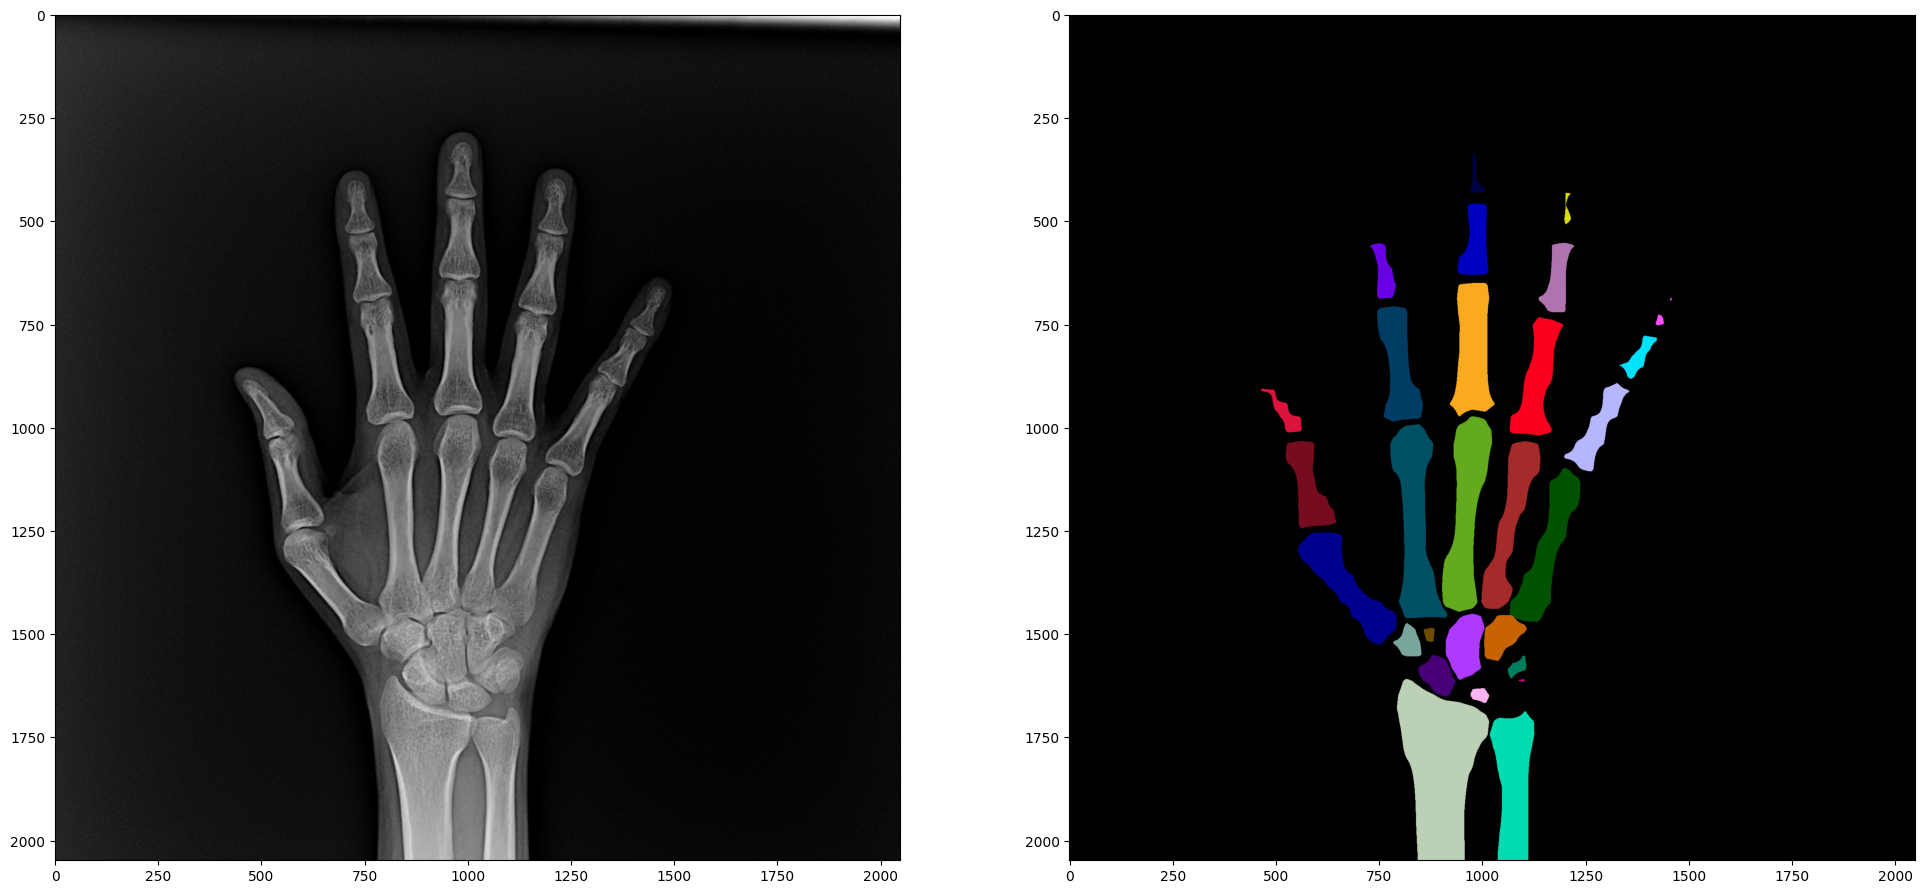

                image_name       class  \
0   image1661319116107.png    finger-1   
1   image1661319116107.png    finger-2   
2   image1661319116107.png    finger-3   
3   image1661319116107.png    finger-4   
4   image1661319116107.png    finger-5   
5   image1661319116107.png    finger-6   
6   image1661319116107.png    finger-7   
7   image1661319116107.png    finger-8   
8   image1661319116107.png    finger-9   
9   image1661319116107.png   finger-10   
10  image1661319116107.png   finger-11   
11  image1661319116107.png   finger-12   
12  image1661319116107.png   finger-13   
13  image1661319116107.png   finger-14   
14  image1661319116107.png   finger-15   
15  image1661319116107.png   finger-16   
16  image1661319116107.png   finger-17   
17  image1661319116107.png   finger-18   
18  image1661319116107.png   finger-19   
19  image1661319116107.png   Trapezium   
20  image1661319116107.png   Trapezoid   
21  image1661319116107.png    Capitate   
22  image1661319116107.png      Ha

100%|██████████| 144/144 [00:46<00:00,  3.09it/s]


finger-1_ID040/image1661319116107.png


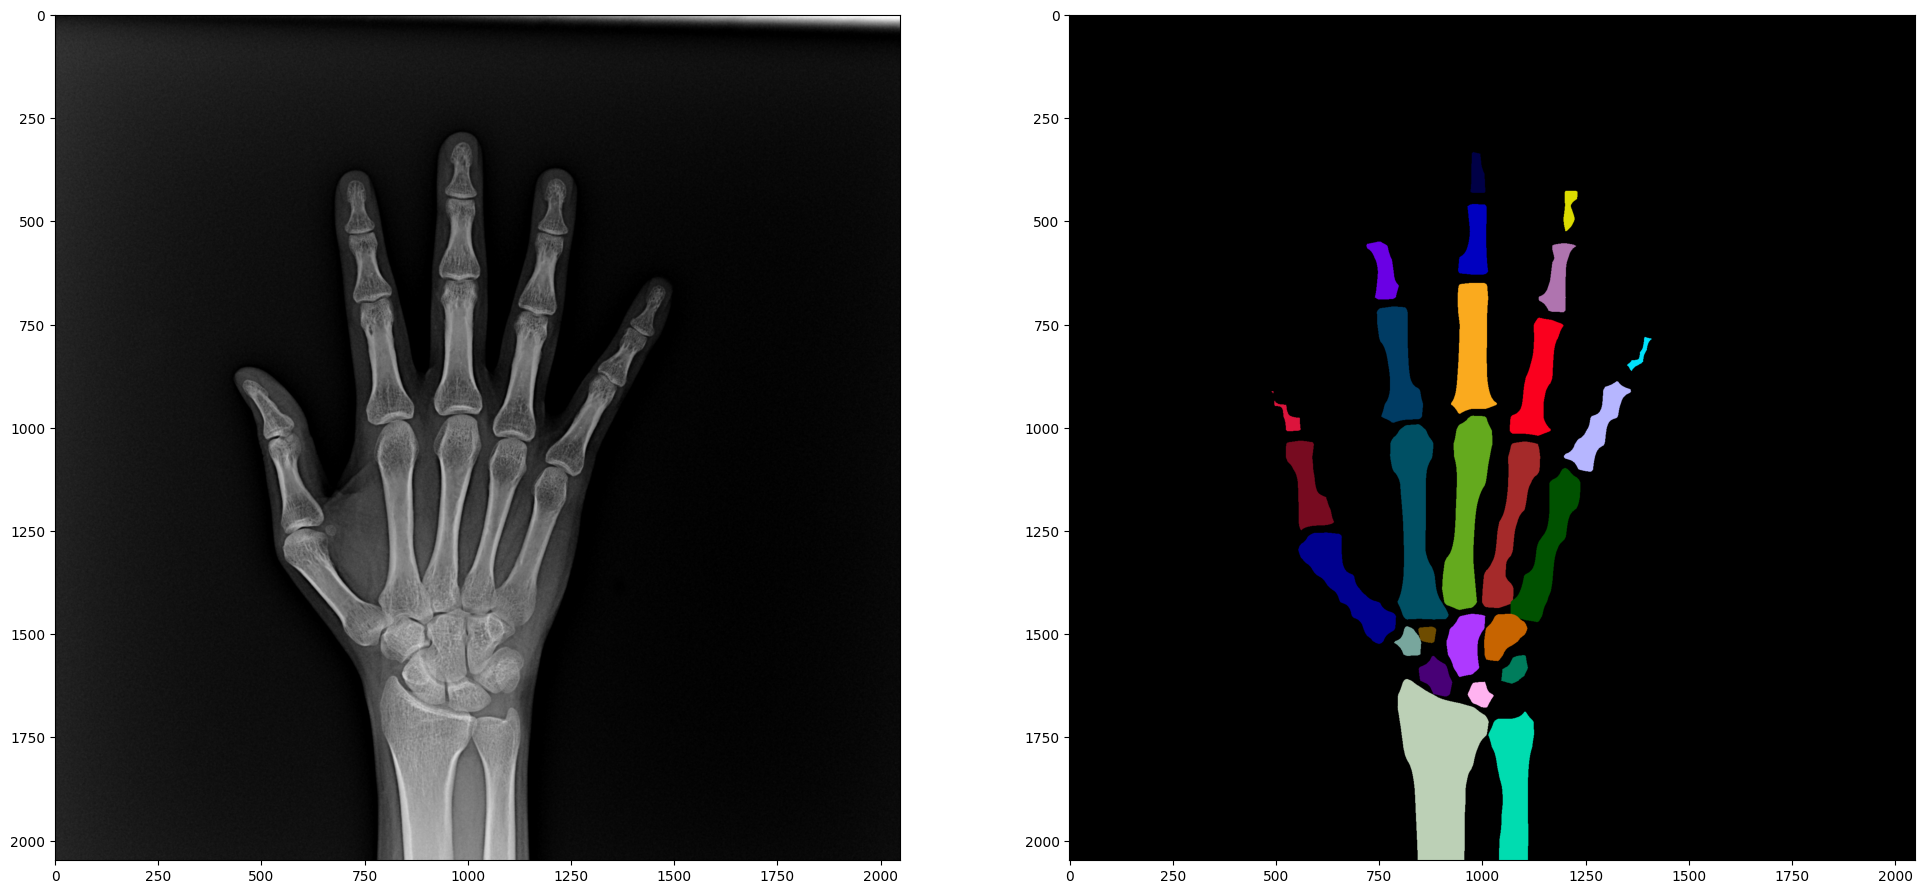

                image_name       class  \
0   image1661319116107.png    finger-1   
1   image1661319116107.png    finger-2   
2   image1661319116107.png    finger-3   
3   image1661319116107.png    finger-4   
4   image1661319116107.png    finger-5   
5   image1661319116107.png    finger-6   
6   image1661319116107.png    finger-7   
7   image1661319116107.png    finger-8   
8   image1661319116107.png    finger-9   
9   image1661319116107.png   finger-10   
10  image1661319116107.png   finger-11   
11  image1661319116107.png   finger-12   
12  image1661319116107.png   finger-13   
13  image1661319116107.png   finger-14   
14  image1661319116107.png   finger-15   
15  image1661319116107.png   finger-16   
16  image1661319116107.png   finger-17   
17  image1661319116107.png   finger-18   
18  image1661319116107.png   finger-19   
19  image1661319116107.png   Trapezium   
20  image1661319116107.png   Trapezoid   
21  image1661319116107.png    Capitate   
22  image1661319116107.png      Ha

100%|██████████| 144/144 [00:46<00:00,  3.10it/s]


finger-1_ID040/image1661319116107.png


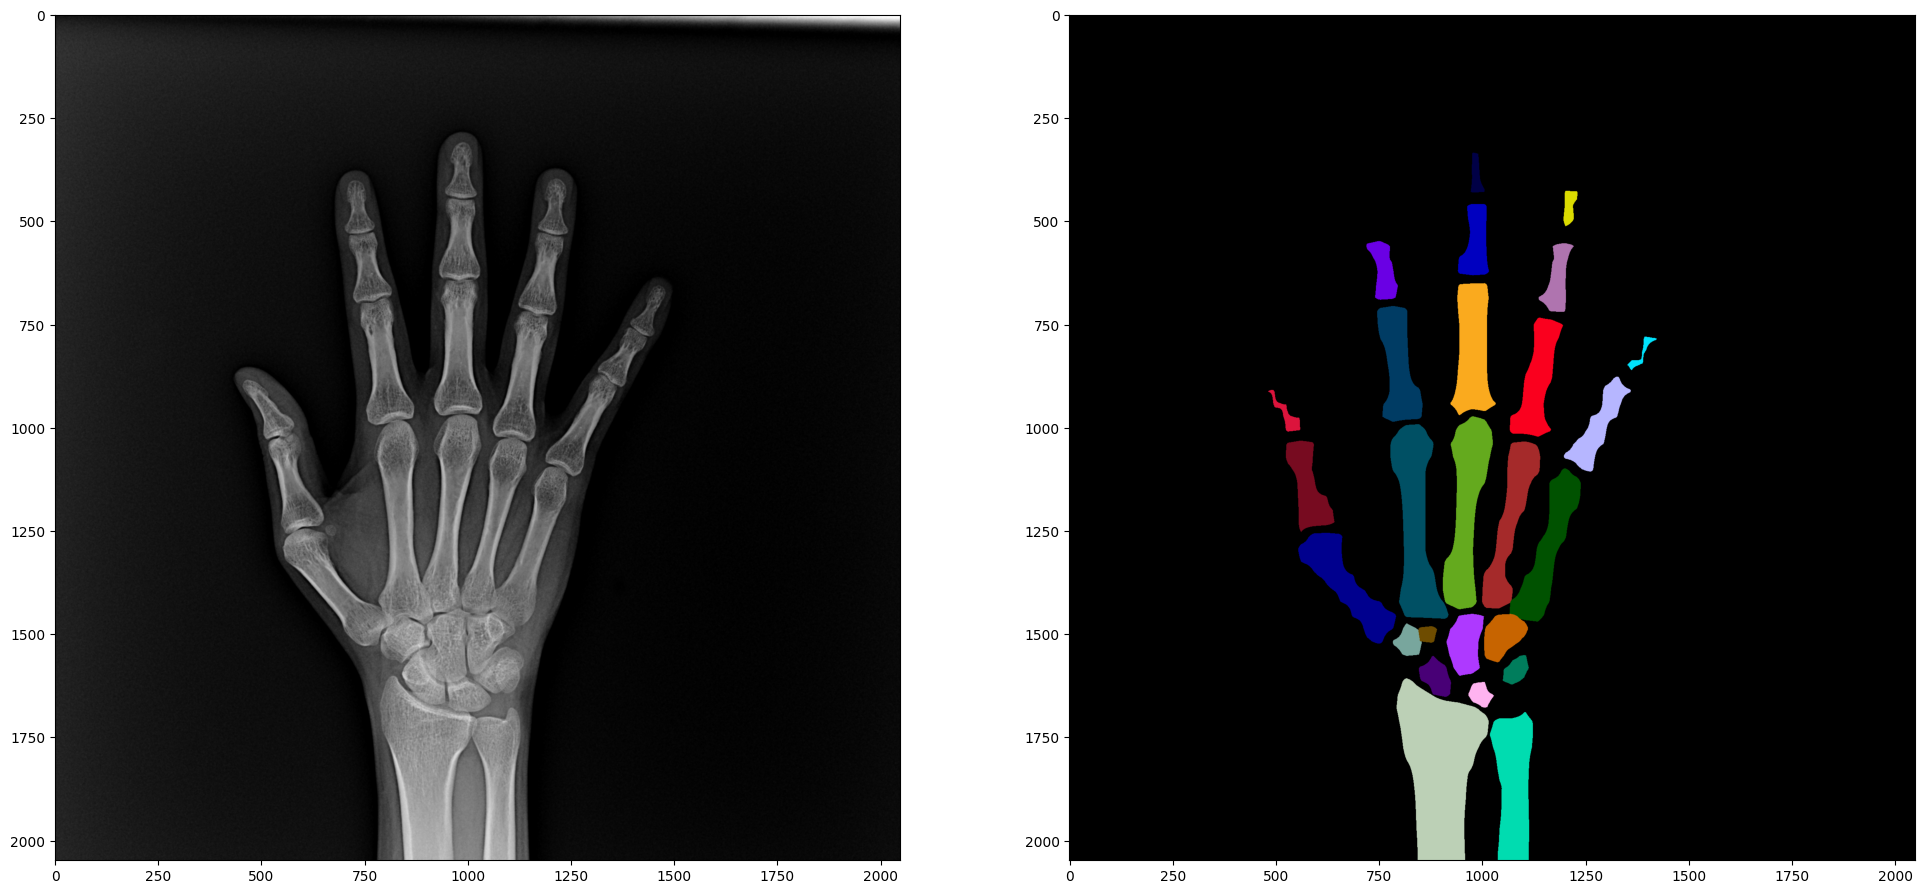

                image_name       class  \
0   image1661319116107.png    finger-1   
1   image1661319116107.png    finger-2   
2   image1661319116107.png    finger-3   
3   image1661319116107.png    finger-4   
4   image1661319116107.png    finger-5   
5   image1661319116107.png    finger-6   
6   image1661319116107.png    finger-7   
7   image1661319116107.png    finger-8   
8   image1661319116107.png    finger-9   
9   image1661319116107.png   finger-10   
10  image1661319116107.png   finger-11   
11  image1661319116107.png   finger-12   
12  image1661319116107.png   finger-13   
13  image1661319116107.png   finger-14   
14  image1661319116107.png   finger-15   
15  image1661319116107.png   finger-16   
16  image1661319116107.png   finger-17   
17  image1661319116107.png   finger-18   
18  image1661319116107.png   finger-19   
19  image1661319116107.png   Trapezium   
20  image1661319116107.png   Trapezoid   
21  image1661319116107.png    Capitate   
22  image1661319116107.png      Ha

100%|██████████| 144/144 [00:45<00:00,  3.18it/s]


finger-1_ID040/image1661319116107.png


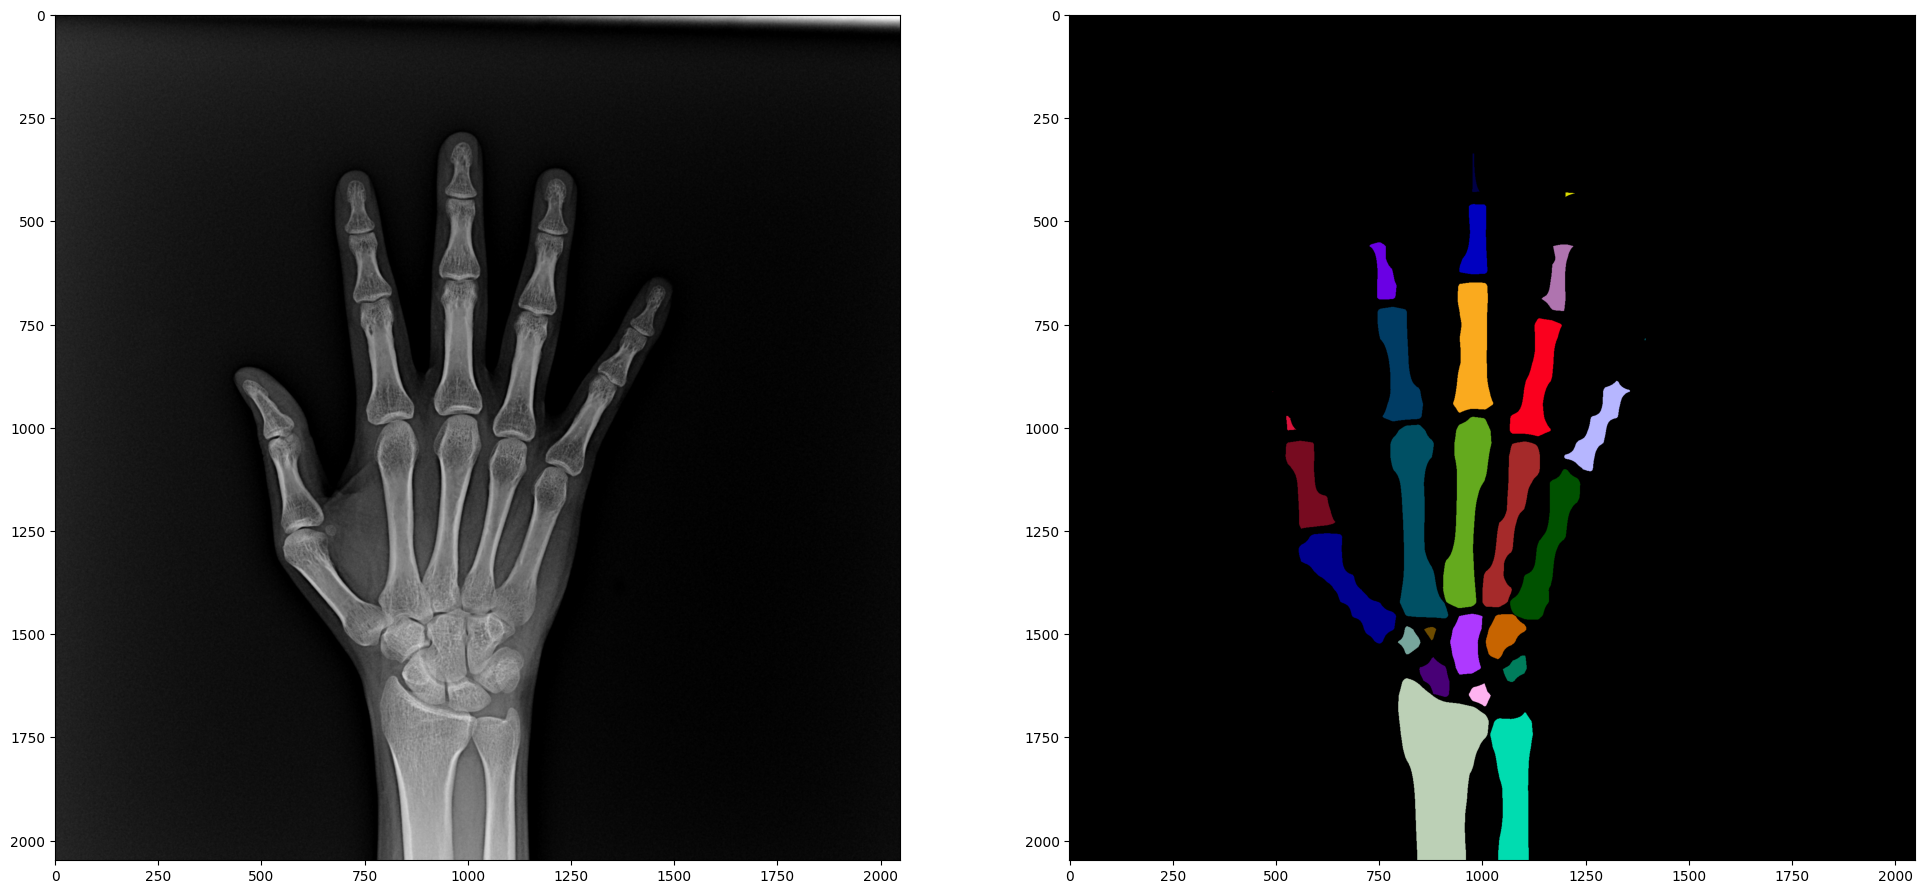

                image_name       class  \
0   image1661319116107.png    finger-1   
1   image1661319116107.png    finger-2   
2   image1661319116107.png    finger-3   
3   image1661319116107.png    finger-4   
4   image1661319116107.png    finger-5   
5   image1661319116107.png    finger-6   
6   image1661319116107.png    finger-7   
7   image1661319116107.png    finger-8   
8   image1661319116107.png    finger-9   
9   image1661319116107.png   finger-10   
10  image1661319116107.png   finger-11   
11  image1661319116107.png   finger-12   
12  image1661319116107.png   finger-13   
13  image1661319116107.png   finger-14   
14  image1661319116107.png   finger-15   
15  image1661319116107.png   finger-16   
16  image1661319116107.png   finger-17   
17  image1661319116107.png   finger-18   
18  image1661319116107.png   finger-19   
19  image1661319116107.png   Trapezium   
20  image1661319116107.png   Trapezoid   
21  image1661319116107.png    Capitate   
22  image1661319116107.png      Ha

100%|██████████| 144/144 [00:45<00:00,  3.19it/s]


finger-1_ID040/image1661319116107.png


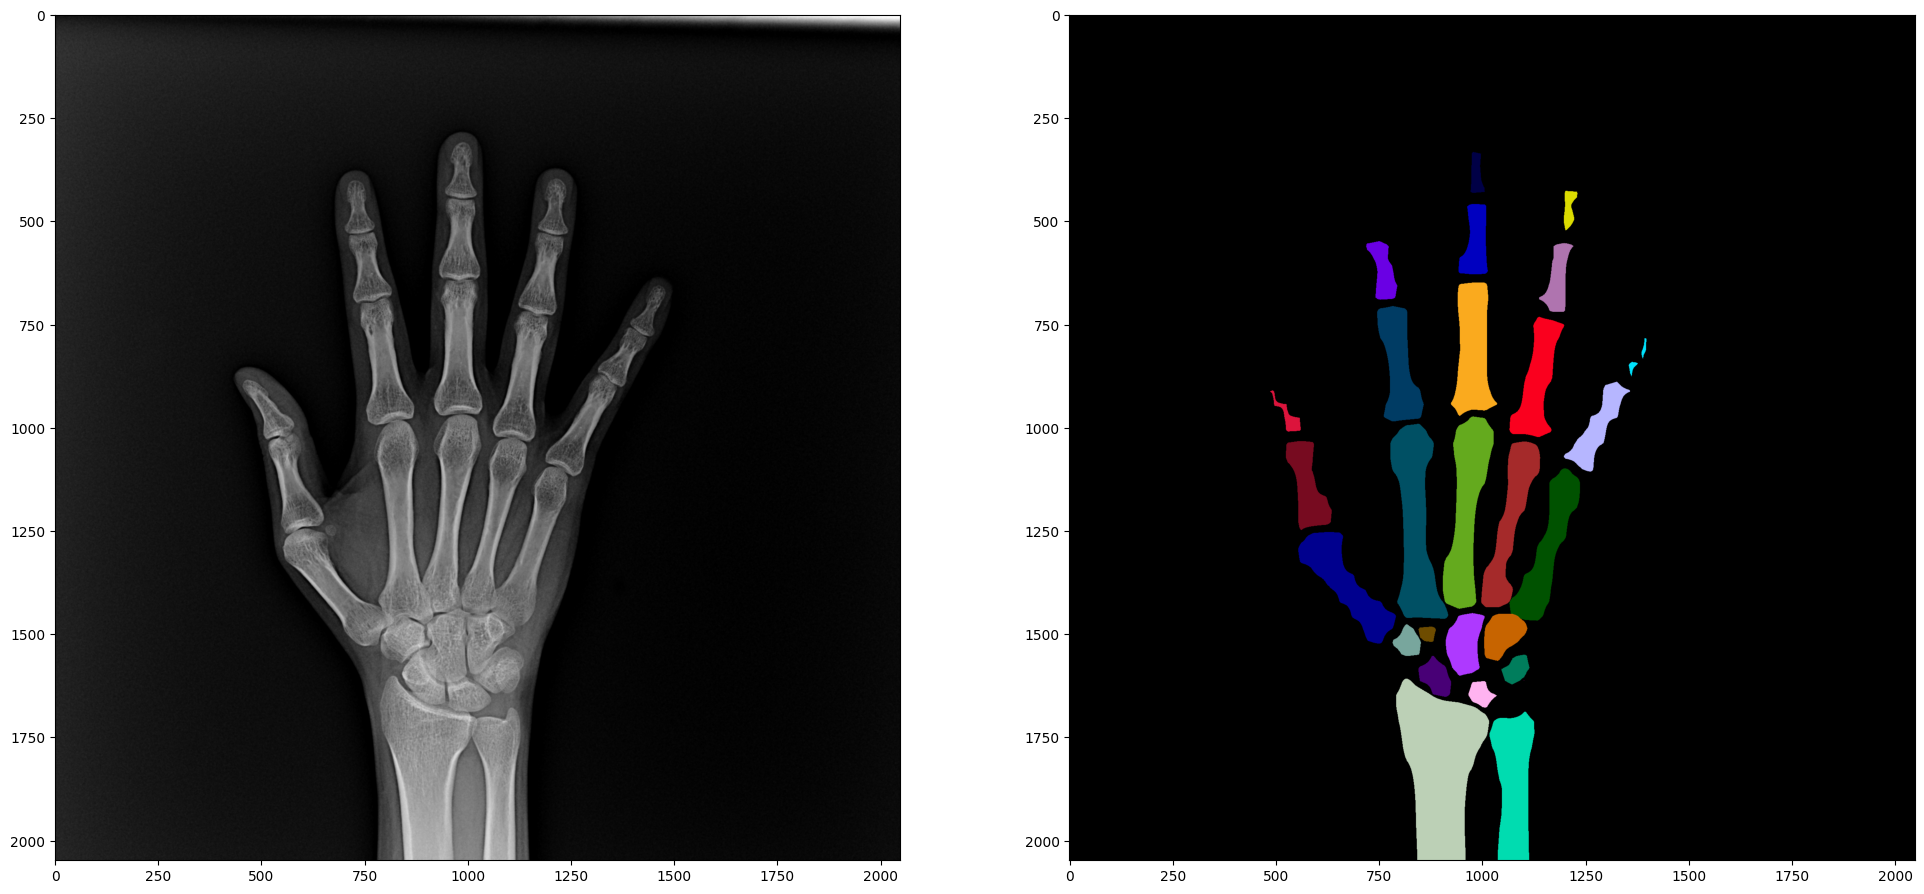

                image_name       class  \
0   image1661319116107.png    finger-1   
1   image1661319116107.png    finger-2   
2   image1661319116107.png    finger-3   
3   image1661319116107.png    finger-4   
4   image1661319116107.png    finger-5   
5   image1661319116107.png    finger-6   
6   image1661319116107.png    finger-7   
7   image1661319116107.png    finger-8   
8   image1661319116107.png    finger-9   
9   image1661319116107.png   finger-10   
10  image1661319116107.png   finger-11   
11  image1661319116107.png   finger-12   
12  image1661319116107.png   finger-13   
13  image1661319116107.png   finger-14   
14  image1661319116107.png   finger-15   
15  image1661319116107.png   finger-16   
16  image1661319116107.png   finger-17   
17  image1661319116107.png   finger-18   
18  image1661319116107.png   finger-19   
19  image1661319116107.png   Trapezium   
20  image1661319116107.png   Trapezoid   
21  image1661319116107.png    Capitate   
22  image1661319116107.png      Ha

In [37]:
run_fold_inference(n_splits=5)